In [29]:
import sys
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import json
import numpy as np

%matplotlib notebook

path = "./"
code_ver=2
if code_ver is 1: file_name = "./dataFile_originalProgram.txt"
if code_ver is 2: file_name = "./dataFile.txt"

#file_name = "./dataFile_readtime120.txt"
#file_name = "./dataFile_sh15.txt" #For shield 15 test.

dataFile = path + file_name

class IMUData():
    def __init__(self):

        self.time = []; self.temp = []
        self.ax = []; self.ay = []; self.az = []
        self.mx = []; self.my = []; self.mz = []
        self.gx = []; self.gy = []; self.gz = []
        
class SweepData():
    def __init__(self):
        self.time = []
        self.pip0 = []; self.pip1 = [];
        
class PayloadData():
    def __init__(self):
        self.rawData = ''
        self.imu = IMUData()
        self.sweeps = SweepData()
        self.macAddress = ''
        self.rssiData = []
        self.shieldID = 0
        
# Functions for merging bytes
def combine2(a, b):
    return (a << 8) | b
def combine4(a, b, c, d):
    return (a << 24) | (b << 16) | (c << 8) | d

# Functions for saving data
def convertDataToLists(dataSet):
    dataSet.imu.ax = dataSet.imu.ax.tolist()
    dataSet.imu.ay = dataSet.imu.ay.tolist()
    dataSet.imu.az = dataSet.imu.az.tolist()
    dataSet.imu.mx = dataSet.imu.mx.tolist()
    dataSet.imu.my = dataSet.imu.my.tolist()
    dataSet.imu.mz = dataSet.imu.mz.tolist()
    dataSet.imu.gx = dataSet.imu.gx.tolist()
    dataSet.imu.gy = dataSet.imu.gy.tolist()
    dataSet.imu.gz = dataSet.imu.gz.tolist()
    dataSet.imu.temp = dataSet.imu.temp.tolist()
    dataSet.imu.time = dataSet.imu.time.tolist()
    dataSet.sweeps.time = dataSet.sweeps.time.tolist()
    dataSet.sweeps.pip0 = dataSet.sweeps.pip0.tolist()
    dataSet.sweeps.pip1 = dataSet.sweeps.pip1.tolist()
    return dataSet

def makeJSONFile (fname, payloadData):
    f = open(fname, 'w')
    # Convert into lists and dictionaries for JSON storage
    payloadData = convertDataToLists(payloadData)
    JSONDict = {}
    # First the IMU data
    imu = payloadData.imu
    imuData = {"time":imu.time, "temp":imu.temp,
               "ax":imu.ax, "ay":imu.ay, "az":imu.az,
               "mx":imu.mx, "my":imu.my, "mz":imu.mz,
               "gx":imu.gx, "gy":imu.gy, "gz":imu.gz}
    JSONDict["imu"] = imuData
    # Then the sweep data
    sweeps = payloadData.sweeps
    sweepData = {"id":sweeps.payloadID, "time":sweeps.time, "pip0":sweeps.pip0, "pip1":sweeps.pip1}
    JSONDict["sweeps"] = sweepData

    json.dump(JSONDict, f)
    f.close()

In [30]:
########### Load the data file ###########
f = open(dataFile, 'r')
rawData = f.read()

# Create payload objects and store parsed data
mainPIPData = PayloadData()
mainPIPData.rawData = rawData
payloads = [mainPIPData]

########### Parse by data type for each payload ###########
strict_parse = True # Require a pound symbol at the end of the data
for payload in payloads:
    payloadrawData = payload.rawData
    imu = []
    sweeps = []
    # 2 PIPs with 28 2-byte samples + 4-byte timestamp + ID
    sweepSamples = 28
    numSweepBytes = sweepSamples * 2 * 2 + 4 + 1
    # 9 2-byte data points + 2-byte temp + 4-byte timestamp
    numIMUBytes = 24
    pntr = 0
    while pntr < len(payloadrawData):
        # Check message start sentinels and not at end
        if payloadrawData[pntr] == '#' and (len(payloadrawData)-pntr) >= numIMUBytes:
            if payloadrawData[pntr+1] == 'I':
                # If not the last, check message end sentinel
                if pntr+2+numIMUBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == '#':
                        imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                # Or just add the last message
                else:
                    imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'S':
                if  pntr+2+numSweepBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == '#':
                        sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                else:
                    sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                pntr += 1
            else:
                pntr += 1
        else:
            pntr += 1
    print("Num IMU Messages: %s" %len(imu))
    print("Num Sweep Messages: %s" %len(sweeps))

    ########### Build data structures ###########
    # First the IMU
    imuTime = [];
    ax = []; ay = []; az = []
    mx = []; my = []; mz = []
    gx = []; gy = []; gz = []
    temp = [];
    for i in imu:
        if len(i) == numIMUBytes:
            imuTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            # The byte order is reversed, but the data sets are not
            ax.append(combine2(ord(i[5]), ord(i[4])))
            ay.append(combine2(ord(i[7]), ord(i[6])))
            az.append(combine2(ord(i[9]), ord(i[8])))
            mx.append(combine2(ord(i[11]), ord(i[10])))
            my.append(combine2(ord(i[13]), ord(i[12])))
            mz.append(combine2(ord(i[15]), ord(i[14])))
            gx.append(combine2(ord(i[17]), ord(i[16])))
            gy.append(combine2(ord(i[19]), ord(i[18])))
            gz.append(combine2(ord(i[21]), ord(i[20])))
            temp.append(combine2(ord(i[23]), ord(i[22])))

    imuTime = np.array(imuTime, dtype='uint32')
    ax = np.array(ax, dtype='int16')
    ay = np.array(ay, dtype='int16')
    az = np.array(az, dtype='int16')
    mx = np.array(mx, dtype='int16')
    my = np.array(my, dtype='int16')
    mz = np.array(mz, dtype='int16')
    gx = np.array(gx, dtype='int16')
    gy = np.array(gy, dtype='int16')
    gz = np.array(gz, dtype='int16')
    temp = np.array(temp, dtype='int16')

    payload.imu.time = imuTime
    payload.imu.ax = ax
    payload.imu.ay = ay
    payload.imu.az = az
    payload.imu.mx = mx
    payload.imu.my = my
    payload.imu.mz = mz
    payload.imu.gx = gx
    payload.imu.gy = gy
    payload.imu.gz = gz
    payload.imu.temp = temp

    # Then the sweeps
    payloadID = [];
    sweepTime = []
    allSweepsPIP0 = []
    individualSweepsPIP0 = []
    allSweepsPIP1 = []
    individualSweepsPIP1 = []
    PIP0StartByte = 4 + 1                             # Four for time, one payload ID  
    PIP0StopByte = PIP0StartByte + sweepSamples*2   # Number of samples, two bytes each
    PIP1StopByte = PIP0StopByte + sweepSamples*2      # Number of samples, two bytes each
    for i in sweeps:
        if len(i) == numSweepBytes:
            sweepTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            payloadID.append(ord(i[4]))
            tempSweep = []
            for byte in xrange(PIP0StartByte,PIP0StopByte,2):
                allSweepsPIP0.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweep.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP0.append(tempSweep)
            tempSweep = []
            for byte in xrange(PIP0StopByte,PIP1StopByte,2):
                allSweepsPIP1.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweep.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP1.append(tempSweep)
    payloadMatch = (len(set(payloadID)) == 1)
    if payloadMatch:
        print("Payload ID's match. This was payload #%s." %payloadID[0])
    else:
        print("Payload ID's don't match. Something went wrong...")
        
    sweepTime = np.array(sweepTime, dtype='uint32')
    individualSweepsPIP0 = np.array(individualSweepsPIP0, dtype='int16')
    individualSweepsPIP1 = np.array(individualSweepsPIP1, dtype='int16')
    payload.shieldID = payloadID[0]
    payload.sweeps.time = sweepTime
    payload.sweeps.pip0 = individualSweepsPIP0
    payload.sweeps.pip1 = individualSweepsPIP1

Num IMU Messages: 2698
Num Sweep Messages: 2697
Payload ID's match. This was payload #15.


<IPython.core.display.Javascript object>


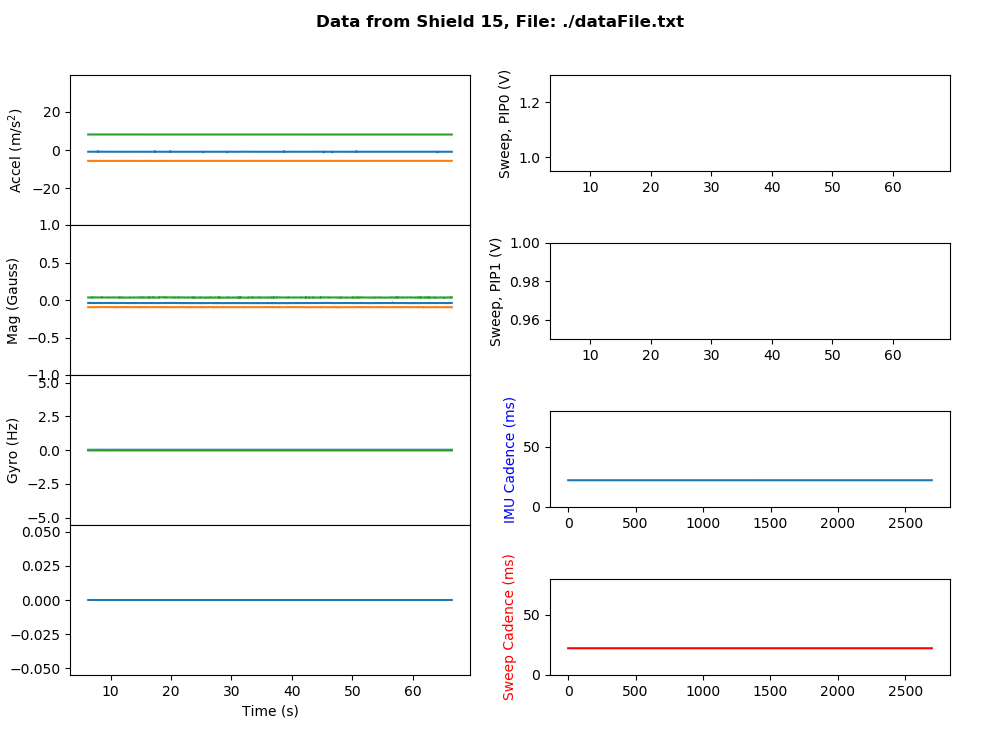

In [42]:
dots = False
# If true display a plot of each sequential sweep sample
# If false display a plot of the voltage for each sweep step
flatten = True
sweepSize = 28
sweepStepDt = 0.02 / sweepSize

# Define as None for no limits
timeMin = None
timeMax = None

# Set by the time limits automatically
timesToSkip = 30 # To impove the quality of sample numbering selection
IMUSampleMin = None
IMUSampleMax = None
SweepSampleMin = None
SweepSampleMax = None

gs_left = plt.GridSpec(4, 2,  hspace=0)
gs_right = plt.GridSpec(4, 2)

# Set up dots or not more cleanly
line_style = '-'
if dots:
    line_style = 'o'

for payload in payloads:
    # Extract data from each set, cast into arrays
    aScale = 4*9.8; mScale = 1.; gScale = 2000./360
    imuTime = np.array(payload.imu.time)/1.E6;
    sweepTime = np.array(payload.sweeps.time)/1.E6
    # Figure out what the sample bounds should be
    if timeMin:
        IMUSampleMin = np.where(imuTime>=timeMin)[0][timesToSkip]
        IMUSampleMax = np.where(imuTime<=timeMax)[0][-1 * timesToSkip]
        SweepSampleMin = np.where(sweepTime>=timeMin)[0][timesToSkip]
        SweepSampleMax = np.where(sweepTime<=timeMax)[0][-1 * timesToSkip]
    imuTime = imuTime[IMUSampleMin:IMUSampleMax]
    sweepTime = sweepTime[SweepSampleMin:SweepSampleMax]
    # Flatten out sweepSampleTime 
    sweepSampleTime = []
    for t in sweepTime:
        for n in range(0, sweepSize):
            sweepSampleTime.append(t+sweepStepDt*n)
    sweepSampleTime = np.array(sweepSampleTime)
    # Make everything an array
    temp = payload.imu.temp[IMUSampleMin:IMUSampleMax];
    ax = np.array(payload.imu.ax[IMUSampleMin:IMUSampleMax])*aScale/2**15
    ay = np.array(payload.imu.ay[IMUSampleMin:IMUSampleMax])*aScale/2**15
    az = np.array(payload.imu.az[IMUSampleMin:IMUSampleMax])*aScale/2**15
    mx = np.array(payload.imu.mx[IMUSampleMin:IMUSampleMax])*mScale/2**15
    my = np.array(payload.imu.my[IMUSampleMin:IMUSampleMax])*mScale/2**15
    mz = np.array(payload.imu.mz[IMUSampleMin:IMUSampleMax])*mScale/2**15
    gx = np.array(payload.imu.gx[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gy = np.array(payload.imu.gy[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gz = np.array(payload.imu.gz[IMUSampleMin:IMUSampleMax])*gScale/2**15
    shieldID = payload.shieldID
    pip0 = np.array(payload.sweeps.pip0)*5./2**14
    pip1 = np.array(payload.sweeps.pip1)*5./2**14
    # Flatten out the pip items
    if flatten:
        pip1 = pip1.flatten();
        pip0 = pip0.flatten();
        if SweepSampleMin:
            SweepSampleMin = SweepSampleMin * sweepSize # Scale up sizing
        if SweepSampleMax:
            SweepSampleMax = SweepSampleMax * sweepSize
    else:
        sweepSampleTime = sweepTime # Not flat => plotting the nth step of each sweep for each time

    # Plot IMU data
    # Acceleration
    fig = plt.figure(figsize=(10, 7.5))
    axis = fig.add_subplot(gs_left[0,0])
    plt.plot(imuTime, ax, line_style)
    plt.plot(imuTime, ay, line_style)
    plt.plot(imuTime, az, line_style)
    plt.ylabel("Accel (m/s$^2$)")
    plt.ylim([-aScale, aScale])
    plt.xlim([timeMin, timeMax])
    plt.xticks(visible=False)
    # Mag
    fig.add_subplot(gs_left[1,0], sharex=axis)
    plt.plot(imuTime, mx, line_style)
    plt.plot(imuTime, my, line_style)
    plt.plot(imuTime, mz, line_style)
    plt.ylabel("Mag (Gauss)")
    plt.ylim([-mScale, mScale])
    plt.xlim([timeMin, timeMax])
    plt.xticks(visible=False)
    # Gyro
    fig.add_subplot(gs_left[2,0], sharex=axis)
    plt.plot(imuTime, gx, line_style)
    plt.plot(imuTime, gy, line_style)
    plt.plot(imuTime, gz, line_style)
    plt.ylabel("Gyro (Hz)")
    plt.ylim([-gScale, gScale])
    plt.xlim([timeMin, timeMax])
    plt.xticks(visible=False)
    # Temperature
    fig.add_subplot(gs_left[3,0], sharex=axis)
    plt.plot(imuTime, temp, line_style)
    plt.xlim([timeMin, timeMax])
    plt.ylabel("Temp C$^o$")
    plt.xlabel("Time (s)")

    # Plot sweep data
    # First PIP
    fig.add_subplot(gs_right[0,1])
    plt.plot(sweepSampleTime, pip0[SweepSampleMin:SweepSampleMax], line_style)
    plt.ylabel("Sweep, PIP0 (V)")
    plt.ylim(0.95, 1.3)
    plt.xlim([timeMin, timeMax])

    # Second PIP
    fig.add_subplot(gs_right[1,1])
    plt.ylim(0.95, 1.)
    plt.plot(sweepSampleTime, pip1[SweepSampleMin:SweepSampleMax], line_style)
    plt.xlim([timeMin, timeMax])
    plt.ylabel("Sweep, PIP1 (V)")

    # IMU Cadence
    fig.add_subplot(gs_right[2,1])
    x = np.linspace(0, len(imuTime), len(sweepTime)-1)
    ave = np.mean(np.diff(imuTime))*1E3
    limit = 0.005*ave # Limits are 5% variation in cadence
    plt.plot(np.diff(imuTime)*1E3, line_style)
    plt.xlim([timeMin, timeMax])
    plt.ylim([0, 4*20])
    #\plt.ylim([0, 50])
    plt.ylabel("IMU Cadence (ms)", color='blue')

    # Sampling Cadence
    fig.add_subplot(gs_right[3,1])
    ave = np.mean(np.diff(sweepTime))*1E3
    limit = 0.005*ave # Limits are 5% variation in cadence
    plt.plot(x, np.diff(sweepTime)*1E3, line_style, color='red')
    plt.xlim([timeMin, timeMax])    
    #plt.ylim([0, 50])
    plt.ylim([0, 4*20])
    plt.ylabel("Sweep Cadence (ms)", color='red')

        
# Adjust figure
fig.subplots_adjust(right=.95)
fig.subplots_adjust(left=0.07)
fig.subplots_adjust(top=0.90)
fig.subplots_adjust(bottom=0.10)
fig.subplots_adjust(hspace=0.75)
plt.suptitle("Data from Shield %s, File: %s" %(shieldID, file_name), fontweight='bold')
    
plt.show()


# outfile = open("exportdata.txt", 'w')
# outfile.write(payload.imu.time)

# np.savetxt("ax.txt", ax)
# np.savetxt("ay.txt", ay)
# np.savetxt("az.txt", az)
# np.savetxt("imuTime.txt", imuTime)
# np.savetxt("sweepTime.txt", sweepTime)plt.ylim([0, 4*20])

In [43]:
figfname='Shield_%s-%s.png'%(shieldID, file_name[2:-4])
#figfname='Shield_%s-%s-Custom_Scales.png'%(shieldID, file_name[2:-4])
fig.savefig(path+figfname)

In [36]:
sweepCad=np.diff(sweepTime)
cadences = np.unique(sweepCad)

In [41]:
print 1./cadences
print np.round(np.min(1./cadences), decimals=2), 'Hz -', np.round(np.max(1./cadences), decimals=2),'Hz' 

[44.86719311 44.86719311 44.85914229 44.85914229 44.85914229 44.85109437
 44.85109437 44.85109437 44.85109437 44.85109437 44.85109437 44.84304933
 44.84304933 44.84304933 44.84304933 44.84304933 44.84304933 44.83500717
 44.83500717 44.83500717 44.83500717 44.83500717 44.83500717 44.8269679
 44.8269679  44.8269679  44.8269679  44.81893152]
44.82 Hz - 44.87 Hz


<IPython.core.display.Javascript object>


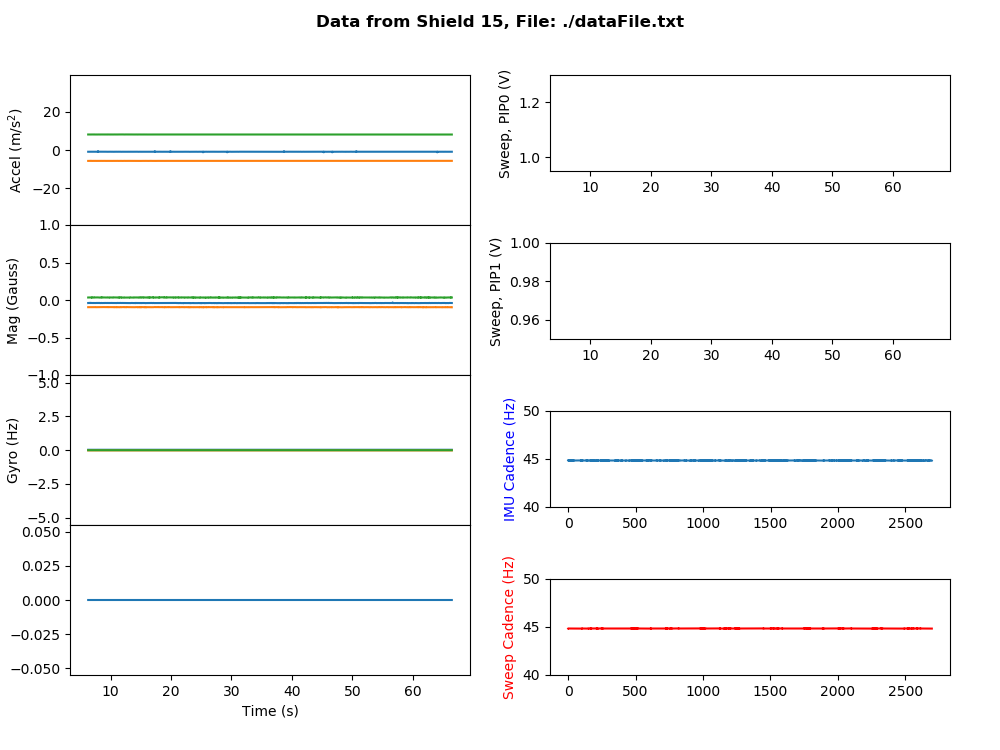

In [38]:
for payload in payloads:
    # Extract data from each set, cast into arrays
    aScale = 4*9.8; mScale = 1.; gScale = 2000./360
    imuTime = np.array(payload.imu.time)/1.E6;
    sweepTime = np.array(payload.sweeps.time)/1.E6
    # Figure out what the sample bounds should be
    if timeMin:
        IMUSampleMin = np.where(imuTime>=timeMin)[0][timesToSkip]
        IMUSampleMax = np.where(imuTime<=timeMax)[0][-1 * timesToSkip]
        SweepSampleMin = np.where(sweepTime>=timeMin)[0][timesToSkip]
        SweepSampleMax = np.where(sweepTime<=timeMax)[0][-1 * timesToSkip]
    imuTime = imuTime[IMUSampleMin:IMUSampleMax]
    sweepTime = sweepTime[SweepSampleMin:SweepSampleMax]
    # Flatten out sweepSampleTime 
    sweepSampleTime = []
    for t in sweepTime:
        for n in range(0, sweepSize):
            sweepSampleTime.append(t+sweepStepDt*n)
    sweepSampleTime = np.array(sweepSampleTime)
    # Make everything an array
    temp = payload.imu.temp[IMUSampleMin:IMUSampleMax];
    ax = np.array(payload.imu.ax[IMUSampleMin:IMUSampleMax])*aScale/2**15
    ay = np.array(payload.imu.ay[IMUSampleMin:IMUSampleMax])*aScale/2**15
    az = np.array(payload.imu.az[IMUSampleMin:IMUSampleMax])*aScale/2**15
    mx = np.array(payload.imu.mx[IMUSampleMin:IMUSampleMax])*mScale/2**15
    my = np.array(payload.imu.my[IMUSampleMin:IMUSampleMax])*mScale/2**15
    mz = np.array(payload.imu.mz[IMUSampleMin:IMUSampleMax])*mScale/2**15
    gx = np.array(payload.imu.gx[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gy = np.array(payload.imu.gy[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gz = np.array(payload.imu.gz[IMUSampleMin:IMUSampleMax])*gScale/2**15
    shieldID = payload.shieldID
    pip0 = np.array(payload.sweeps.pip0)*5./2**14
    pip1 = np.array(payload.sweeps.pip1)*5./2**14
    # Flatten out the pip items
    if flatten:
        pip1 = pip1.flatten();
        pip0 = pip0.flatten();
        if SweepSampleMin:
            SweepSampleMin = SweepSampleMin * sweepSize # Scale up sizing
        if SweepSampleMax:
            SweepSampleMax = SweepSampleMax * sweepSize
    else:
        sweepSampleTime = sweepTime # Not flat => plotting the nth step of each sweep for each time

    # Plot IMU data
    # Acceleration
    fig = plt.figure(figsize=(10, 7.5))
    axis = fig.add_subplot(gs_left[0,0])
    plt.plot(imuTime, ax, line_style)
    plt.plot(imuTime, ay, line_style)
    plt.plot(imuTime, az, line_style)
    plt.ylabel("Accel (m/s$^2$)")
    plt.ylim([-aScale, aScale])
    plt.xlim([timeMin, timeMax])
    plt.xticks(visible=False)
    # Mag
    fig.add_subplot(gs_left[1,0], sharex=axis)
    plt.plot(imuTime, mx, line_style)
    plt.plot(imuTime, my, line_style)
    plt.plot(imuTime, mz, line_style)
    plt.ylabel("Mag (Gauss)")
    plt.ylim([-mScale, mScale])
    plt.xlim([timeMin, timeMax])
    plt.xticks(visible=False)
    # Gyro
    fig.add_subplot(gs_left[2,0], sharex=axis)
    plt.plot(imuTime, gx, line_style)
    plt.plot(imuTime, gy, line_style)
    plt.plot(imuTime, gz, line_style)
    plt.ylabel("Gyro (Hz)")
    plt.ylim([-gScale, gScale])
    plt.xlim([timeMin, timeMax])
    plt.xticks(visible=False)
    # Temperature
    fig.add_subplot(gs_left[3,0], sharex=axis)
    plt.plot(imuTime, temp, line_style)
    plt.xlim([timeMin, timeMax])
    plt.ylabel("Temp C$^o$")
    plt.xlabel("Time (s)")

    # Plot sweep data
    # First PIP
    fig.add_subplot(gs_right[0,1])
    plt.plot(sweepSampleTime, pip0[SweepSampleMin:SweepSampleMax], line_style)
    plt.ylabel("Sweep, PIP0 (V)")
    plt.ylim(0.95, 1.3)
    plt.xlim([timeMin, timeMax])

    # Second PIP
    fig.add_subplot(gs_right[1,1])
    plt.ylim(0.95, 1.)
    plt.plot(sweepSampleTime, pip1[SweepSampleMin:SweepSampleMax], line_style)
    plt.xlim([timeMin, timeMax])
    plt.ylabel("Sweep, PIP1 (V)")

    # IMU Cadence
    fig.add_subplot(gs_right[2,1])
    x = np.linspace(0, len(imuTime), len(sweepTime)-1)
    ave = np.mean(np.diff(imuTime))*1E3
    limit = 0.005*ave # Limits are 5% variation in cadence
    plt.plot(1./np.diff(imuTime), line_style)
    plt.xlim([timeMin, timeMax])
    #plt.ylim([0, 4*20])
    plt.ylim([40, 50])
    plt.ylabel("IMU Cadence (Hz)", color='blue')

    # Sampling Cadence
    fig.add_subplot(gs_right[3,1])
    ave = np.mean(np.diff(sweepTime))*1E3
    limit = 0.005*ave # Limits are 5% variation in cadence
    plt.plot(x, 1./np.diff(sweepTime), line_style, color='red')
    plt.xlim([timeMin, timeMax])    
    plt.ylim([40, 50])
    #plt.ylim([0, 4*20])
    plt.ylabel("Sweep Cadence (Hz)", color='red')

        
# Adjust figure
fig.subplots_adjust(right=.95)
fig.subplots_adjust(left=0.07)
fig.subplots_adjust(top=0.90)
fig.subplots_adjust(bottom=0.10)
fig.subplots_adjust(hspace=0.75)
plt.suptitle("Data from Shield %s, File: %s" %(shieldID, file_name), fontweight='bold')
    
plt.show()



In [39]:
figfname='SweepsPerSec-Shield_%s-%s.png'%(shieldID, file_name[2:-4])
#figfname='Shield_%s-%s-Custom_Scales.png'%(shieldID, file_name[2:-4])
fig.savefig(path+figfname)